Python code for generating figures used in the paper "What Determines the Sizes of Bars in Spiral Galaxies?" (Erwin 2019, submitted)

### General Setup

In [2]:
%pylab inline

matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 20

# kludge to fix matplotlib's font_manager bug which mistakenly ID's "Times New Roman Bold.ttf" as
# indicating a "roman" (i.e., "normal") weight
try:
    del matplotlib.font_manager.weight_dict['roman']
except KeyError:
    pass
matplotlib.font_manager._rebuild()

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [39]:
import scipy.stats

import plotutils as pu
import datautils as du
from loess import loess_1d as cap_loess_1d

projDir = "/Users/erwin/Documents/Working/Projects/Project_BarSizes/"
sys.path.append("/Users/erwin/Documents/Working/Paper-DB_Catalog/paper-extended-wiyn-survey")
sys.path.append(projDir)
import datasets

s4gdata = datasets.s4gdata

baseDir = "/Users/erwin/Documents/Working/Paper-s4gbars/"
plotDir = baseDir + "plots/"

nDisksTotal = len(s4gdata.name)

mm = np.arange(8,12,0.01)

# set the following to True in order to save the figures as PDF files
savePlots = False

### Useful Functions

In [40]:
# code to make using Cappellari LOESS function more useful
def GetSortedLoess1D( x, y, frac=0.5, degree=1 ):
    ii_sorted = np.argsort(x)
    x_sorted = x[ii_sorted]
    y_sorted = y[ii_sorted]
    x_sorted, y_predicted, w = cap_loess_1d.loess_1d(x_sorted, y_sorted, frac=frac, degree=degree)
    return x_sorted, y_predicted

def GetSortedLoess1DResiduals( x, y, frac=0.5, degree=1 ):
    ii_sorted = np.argsort(x)
    x_sorted = x[ii_sorted]
    y_sorted = y[ii_sorted]
    x_sorted, y_predicted, w = cap_loess_1d.loess_1d(x_sorted, y_sorted, frac=frac, degree=degree)
    return x_sorted, y_sorted - y_predicted, ii_sorted


# code for fits
def simplefunc_brokenlinear( params, x ):
    """Simple function to compute broken-linear fit: 
        y = alpha_1 + beta_1*x,   x < x_break
          = alpha_2 + beta_2*x,   x >= x_break
    
    Parameters
    ----------
    params : sequence of float
        [alpha_1, beta_1, x_break, beta_2]
        note that alpha_2 can be computed from the other parameters
    x : float or numpy ndarray of float
        x values
    
    Returns
    -------
    y : float or numpy ndarray of float
        see definition above
    """

    alpha_1 = params[0]
    beta_1 = params[1]
    x_break = params[2]
    beta_2 = params[3]
    alpha_2 = alpha_1 + (beta_1 - beta_2)*x_break
    if (np.iterable(x) == 0):
        x = [x]
    npts = len(x)
    vals = []
    for i in range(npts):
        if x[i] < x_break:
            value = alpha_1 + beta_1*x[i]
        else:
            value = alpha_2 + beta_2*x[i]
        vals.append(value)
    return np.array(vals)

def simplefunc_linear( params, x ):
    """Simple function to compute linear fit: 
        y = alpha + beta*x
    
    Parameters
    ----------
    params : sequence of float
        [alpha, beta]
    x : float or numpy ndarray of float
        x values
    
    Returns
    -------
    y : float or numpy ndarray of float
        y = alpha + beta*x
    """
    alpha = params[0]
    beta = params[1]
    npts = len(x)
    vals = []
    for i in range(npts):
        value = alpha + beta*x[i]
        vals.append(value)
    return np.array(vals)

def fmulti_lin_brokenlin( X, a, b, a1, b1, x_brk, b2 ):
    """Composite function which combines linear fit (a, b) with broken-linear
    fit (rest of parameters)

    Parameters
    ----------
    X : tuple of x1, x2 
        x1 : 1D numpy ndarray of predictor using linear fit (e.g., log R_e)
        x2 : 1D numpy ndarray of predictor using broken-linear fit (e.g., log M_star)
    a, b, a1, b1, x_brk, b2 : float
        parameters for the model

    Returns
    -------
    yy : ndarray of float
        array of y values
    
    The model is
        y = a + b*x1 + a1 + b1*x2   for x < x_brk
        y = a + b*x1 + a2 + b2*x2   for x > x_brk
    Note that a2 is computed from the other parameters
    """
    # unpack the two independent variables
    # e.g., x1 = log(R_e), x2 = log(M_star)
    x1,x2 = X
    
    a2 = a1 + (b1 - b2)*x_brk
    npts = len(x1)
    yy = []
    for i in range(npts):
        x1_i = x1[i]
        x2_i = x2[i]
        if x2_i < x_brk:
            y_i = a + b*x1_i + a1 + b1*x2_i
        else:
            y_i = a + b*x1_i + a2 + b2*x2_i
        yy.append(y_i)
    return np.array(yy)


### Plot labels

In [41]:
# useful definitions for printing and plotting labels

xtmstar = r"$\log \: (M_{\star} / M_{\odot})$"
xth_kpc = r"Disk scale length $h$ [kpc]"
xtRe_kpc = r"Galaxy half-light radius $R_{e}$ [kpc]"
xtfgas = r"$\log \: (M_{\rm HI} / M_{\star})$"
xtHtype = r"Hubble Type $T$"
ytbarsize_kpc = r"Bar size $a_{\rm vis}$ [kpc]"
ytresid = r"Residuals: $\log \, (a_{\rm vis}) - \log \, ({\rm predicted})$"
ytresid_Re = r"Residuals: $\log \, R_{e, {\rm obs}} - \log \, ({\rm predicted})$"
ytresid_h = r"Residuals: $\log \, h - \log \, ({\rm predicted})$"

s4g_txt = r"S$^{4}$G"
s4g_fwhm = r"S$^{4}$G $\langle$FWHM$\rangle$"
s4g_2fwhm = r"$2 \times$ S$^{4}$G $\langle$FWHM$\rangle$"


### Subsamples

Importing the variables defined in `sample_defs.py` provides lists of int values, which can be used to index numpy 1D arrays, thereby defining different subsamples of S4G.

E.g., the R_e values of all the barred galaxies can be defined as
    
    s4gdata.Re_kpc[ii_barred]

**Location of subsample definitions:** 

/Users/erwin/Documents/Working/Projects/Project_BarSizes/sample_defs.py

In [42]:
from sample_defs import *

For reference, here are the definitions in that file:

In [30]:
# "limited2" or "lim2" = D <= 30 Mpc
# "m9to11 = logmstar = 9--11


# general subsamples: all barred, all unbarred, all spirals
ii_barred = [i for i in range(nDisksTotal) if s4gdata.sma[i] > 0]
ii_unbarred = [i for i in range(nDisksTotal) if s4gdata.sma[i] <= 0]

ii_spirals = [i for i in range(nDisksTotal) if s4gdata.t_s4g[i] > -0.5]


# Limited subsample 2: spirals with D <= 30 Mpc -- 856 galaxies: 483 barred, 373 unbarred
ii_all_limited2 = [i for i in ii_spirals if s4gdata.dist[i] <= 30]
ii_barred_limited2 = [i for i in ii_all_limited2 if i in ii_barred]
ii_unbarred_limited2 = [i for i in ii_all_limited2 if i not in ii_barred]

# Parent Spiral Sample: spirals with D <= 30 Mpc + logMstar = 9--11:
ii_all_limited2_m9to11 = [i for i in ii_all_limited2 if s4gdata.logmstar[i] >= 9 and s4gdata.logmstar[i] <= 11]
ii_barred_limited2_m9to11 = [i for i in ii_all_limited2_m9to11 if i in ii_barred]



# Spirals with R_e *and* h
ii_all_Reh = [i for i in ii_spirals if s4gdata.Re_kpc[i] > 0 and s4gdata.h_kpc[i] > 0]
ii_barred_Reh = [i for i in ii_all_Reh if i in ii_barred]
ii_unbarred_Reh = [i for i in ii_all_Reh if i not in ii_barred]


ii_all_Reh_m9to11 = [i for i in ii_spirals if s4gdata.logmstar[i] >= 9 and s4gdata.logmstar[i] <= 11 and s4gdata.Re_kpc[i] > 0 and s4gdata.h_kpc[i] > 0]
ii_barred_Reh_m9to11 = [i for i in ii_all_Reh_m9to11 if i in ii_barred]
ii_unbarred_Reh_m9to11 = [i for i in ii_all_Reh_m9to11 if i not in ii_barred]

ii_all_limited2_Reh = [i for i in ii_all_Reh if s4gdata.dist[i] <= 30]
ii_barred_limited2_Reh = [i for i in ii_all_limited2_Reh if i in ii_barred]
ii_unbarred_limited2_Reh = [i for i in ii_all_limited2_Reh if i not in ii_barred]

# Main Spiral Sample: Spirals with D < 30 Mpc, valid R_e *and* h, *and* logMstar = 9--11:
ii_all_lim2m9to11_Reh = [i for i in ii_all_limited2_Reh if s4gdata.logmstar[i] >= 9 and s4gdata.logmstar[i] <= 11]
ii_barred_lim2m9to11_Reh = [i for i in ii_all_lim2m9to11_Reh if i in ii_barred]
ii_unbarred_lim2m9to11_Reh = [i for i in ii_all_lim2m9to11_Reh if i not in ii_barred]


# useful aliases which are more directly descriptive
ii_all_D30 = ii_all_limited2
ii_all_D30_m9to11 = ii_all_limited2_m9to11
ii_barred_D30_m9to11 = ii_barred_limited2_m9to11
ii_barred_D30_m9to11_Reh = ii_barred_lim2m9to11_Reh


In [43]:
# global data vectors in log10 format
logbarsize_all = np.log10(s4gdata.sma_dp_kpc2)
logRe_all = np.log10(s4gdata.Re_kpc)
logh_all = np.log10(s4gdata.h_kpc)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


### Get best-fit parameters from file

**Note:** Best-fit parameters are generated (and stored in output file) by Jupyter notebook barsize_fits.ipynb

In [33]:
bestfitParamsFile = projDir + "bestfit_parameters.txt"
dlines = [line for line in open(bestfitParamsFile) if line[0] != '#']
fitDict = {}
for line in dlines:
    pp = line.split(":")
    fitName = pp[0]
    ppp = pp[1].split()
    params = [float(p) for p in ppp]
    fitDict[fitName] = params


## Figure 1: Barsize vs logMstar w/ LOESS and linear + broken-linear fit

plots/barsize-logMstar_loess+fits -- **assembled in Adobe Illustrator**:
   1. plots/barsize-vs-mass-with-loess.pdf
   2. plots/barsize-vs-mass-with-fits_final.pdf


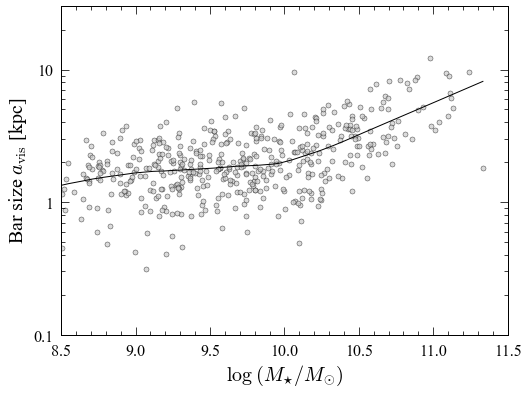

In [45]:
# LOESS fit
s4gxx_05, s4gyy_05 = GetSortedLoess1D(s4gdata.logmstar[ii_barred_limited2], np.log10(s4gdata.sma_dp_kpc2[ii_barred_limited2]), frac=0.5)
s4gyy_05 = 10**s4gyy_05

semilogy(s4gdata.logmstar[ii_barred_limited2], s4gdata.sma_dp_kpc2[ii_barred_limited2], 'ko', mfc='0.8',ms=5, alpha=0.7)
xlim(8.5,11.5);ylim(0.1,30)
plot(s4gxx_05, s4gyy_05, 'k')

xlabel(xtmstar);ylabel(ytbarsize_kpc)
pu.MakeNiceLogAxes(whichAxis="y")
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots:
    plt.savefig(plotDir+"barsize-vs-mass-with-loess.pdf")

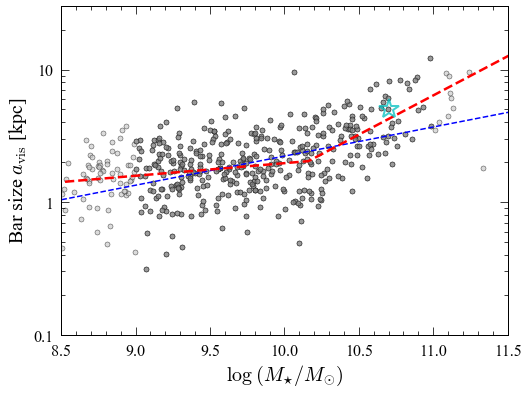

In [38]:
semilogy(s4gdata.logmstar[ii_barred_limited2], s4gdata.sma_dp_kpc2[ii_barred_limited2], 'ko', mfc='0.8',ms=5, alpha=0.7)
semilogy(s4gdata.logmstar[ii_barred_D30_m9to11], s4gdata.sma_dp_kpc2[ii_barred_D30_m9to11], 'ko', mfc='0.5',ms=5, alpha=0.7)
xlim(8.5,11.5);plt.ylim(0.1,30)
plot(mm, 10**np.array(simplefunc_linear(fitDict['barsize-vs-Mstar_lin'], mm)), 'b--', lw=1.5)
plot(mm, 10**np.array(simplefunc_brokenlinear(fitDict['barsize-vs-Mstar_parent_brokenlin'], mm)), 'r--', lw=2.5)
# plot Milky Way
semilogy(10.7, 5.0, '*', mec='c', mew=2, mfc='None', ms=20, alpha=0.75)

xlabel(xtmstar);ylabel(ytbarsize_kpc)
pu.MakeNiceLogAxes(whichAxis="y")
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots:
    plt.savefig(plotDir+"barsize-vs-mass-with-fits_final.pdf")

## Figure 2 -- Barsize vs logMstar using linear barsize

plots/barsize-vs-mass-with-fit_linear.pdf

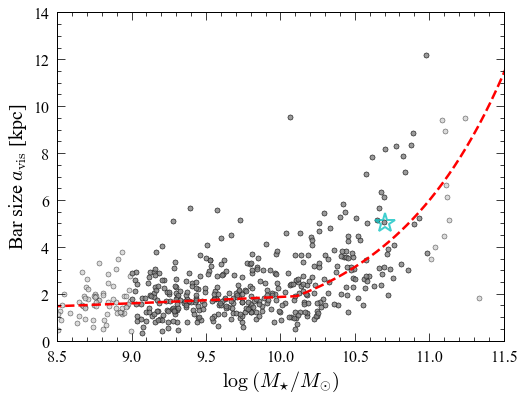

In [36]:
plot(s4gdata.logmstar[ii_barred_limited2], s4gdata.sma_dp_kpc2[ii_barred_limited2], 'ko', mfc='0.8',ms=5, alpha=0.7)
plot(s4gdata.logmstar[ii_barred_D30_m9to11], s4gdata.sma_dp_kpc2[ii_barred_D30_m9to11], 'ko', mfc='0.5',ms=5, alpha=0.7)
xlim(8.5,11.5);ylim(0,14)
plot(mm, 10**np.array(simplefunc_brokenlinear(fitDict['barsize-vs-Mstar_brokenlin'], mm)), 'r--', lw=2.5)
# plot Milky Way
plot(10.7, 5.0, '*', mec='c', mew=2, mfc='None', ms=20, alpha=0.75)
xlabel(xtmstar);ylabel(ytbarsize_kpc)
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots:
    plt.savefig(plotDir+"barsize-vs-mass-with-fit_linear.pdf")

## Figure 3 -- Residuals of barsize vs logR_e and logh, including residuals vs logMstar (4-panel)

plots/barsize-h-Re-fits-and-residuals_4-panel -- **assembled in Adobe Illustrator**:
   1. barsize-Re-fit.pdf
   2. barsize-h-fit.pdf
   3. barsize-Re-residuals-vs_logMstar.pdf
   4. barsize-h-residuals-vs_logMstar.pdf


### Upper-left panel

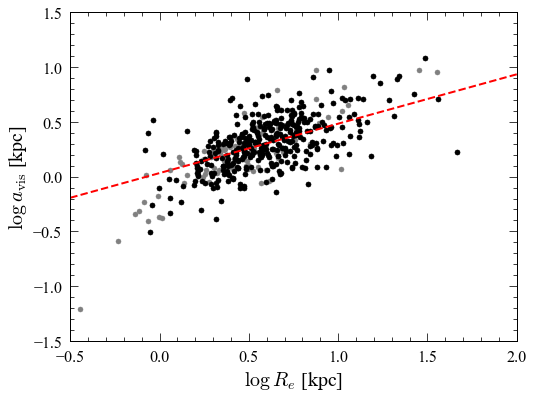

In [12]:
re_vect = np.arange(-0.5,2.6,0.1)
a,b = fitDict['barsize-vs-Re_lin_Reh']

plot(logRe_all[ii_barred_limited2_Reh], logbarsize_all[ii_barred_limited2_Reh], 'o', color='0.5', ms=5)
plot(logRe_all[ii_barred_D30_m9to11_Reh], logbarsize_all[ii_barred_D30_m9to11_Reh], 'ko', ms=5)
plot(re_vect, simplefunc_linear(fitDict['barsize-vs-Re_lin_Reh'], re_vect), 'r--', lw=2)
xlim(-0.5,2)
xlabel(r"$\log \, R_e$ [kpc]")
ylabel(r"$\log \, a_{\rm vis}$ [kpc]")
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots:
    savefig(plotDir+"barsize-Re-fit.pdf")

### Upper-right panel

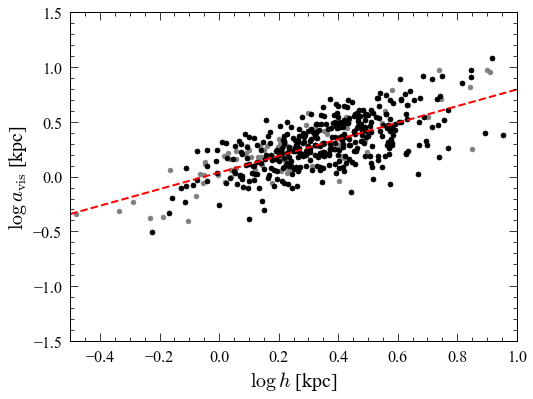

In [13]:
h_vect = np.arange(-0.5,1.01,0.1)

plot(logh_all[ii_barred_limited2_Reh], logbarsize_all[ii_barred_limited2_Reh], 'o', color='0.5', ms=5)
plot(logh_all[ii_barred_D30_m9to11_Reh], logbarsize_all[ii_barred_D30_m9to11_Reh], 'ko', ms=5)
plot(h_vect, simplefunc_linear(fitDict['barsize-vs-h_lin_Reh'], h_vect), 'r--', lw=2)
xlim(-0.5,1.0)
xlabel(r"$\log \, h$ [kpc]")
ylabel(r"$\log \, a_{\rm vis}$ [kpc]")
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots:
    savefig(plotDir+"barsize-h-fit.pdf")

### Compute residuals to fits

In [14]:
barsize_Re_predicted_log = simplefunc_linear(fitDict['barsize-vs-Re_lin_Reh'], logRe_all)
residuals_Re_log = logbarsize_all - barsize_Re_predicted_log

barsize_h_predicted_log = simplefunc_linear(fitDict['barsize-vs-h_lin_Reh'], logh_all)
residuals_h_log = logbarsize_all - barsize_h_predicted_log

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in subtract
  """


### Lower-left panel

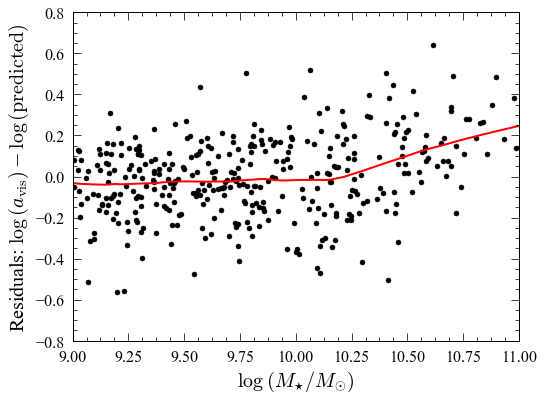

In [15]:
s4gxx_03, s4gyy_03 = GetSortedLoess1D(s4gdata.logmstar[ii_barred_limited2_Reh], residuals_Re_log[ii_barred_limited2_Reh], frac=0.3)

plot(s4gdata.logmstar[ii_barred_D30_m9to11_Reh], residuals_Re_log[ii_barred_D30_m9to11_Reh], 'ko', ms=5)
plot(s4gxx_03, s4gyy_03, 'r-', lw=2)
xlim(9,11.0);ylim(-0.8,0.8)
xlabel(xtmstar);ylabel(ytresid)
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots:
    savefig(plotDir+"barsize-Re-residuals_vs_logMstar.pdf")

### Lower-right panel

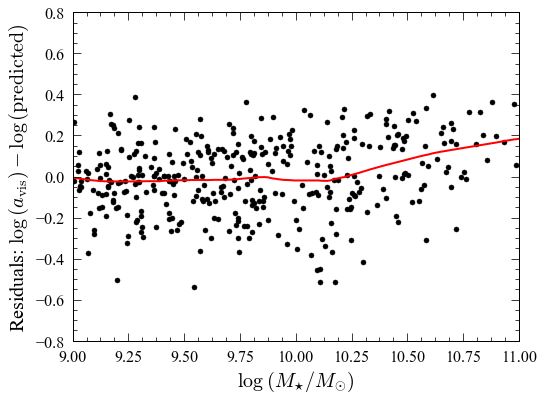

In [16]:
s4gxx_03, s4gyy_03 = GetSortedLoess1D(s4gdata.logmstar[ii_barred_limited2_Reh], residuals_h_log[ii_barred_limited2_Reh], frac=0.3)

plot(s4gdata.logmstar[ii_barred_D30_m9to11_Reh], residuals_h_log[ii_barred_D30_m9to11_Reh], 'ko', ms=5)
plot(s4gxx_03, s4gyy_03, 'r', lw=2)
xlim(9,11.);ylim(-0.8,0.8)
xlabel(xtmstar);ylabel(ytresid)
plt.subplots_adjust(bottom=0.14)
if savePlots:
    savefig(plotDir+"barsize-h-residuals_vs_logMstar.pdf")

## Figure 4 -- Barsize vs gas mass fraction

plots/barsize-vs-logfgas.pdf

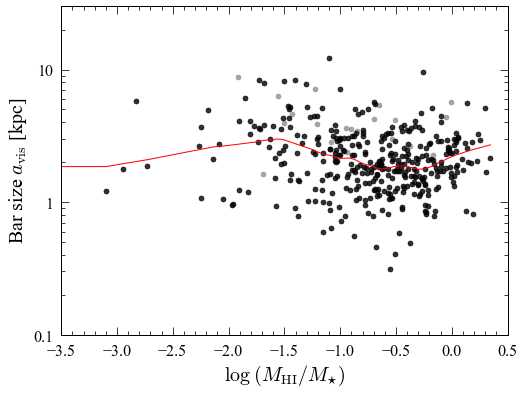

In [44]:
s4gxx, s4gyy = GetSortedLoess1D(s4gdata.logfgas[ii_barred_D30_m9to11], np.log10(s4gdata.sma_dp_kpc2[ii_barred_D30_m9to11]), frac=0.3)
s4gyy = 10**s4gyy

semilogy(s4gdata.logfgas[ii_barred_D30_m9to11], s4gdata.sma_dp_kpc2[ii_barred_D30_m9to11], 'o', color='0.5',mew=0.6, ms=5, alpha=0.7)
semilogy(s4gdata.logfgas[ii_barred_D30_m9to11_Reh], s4gdata.sma_dp_kpc2[ii_barred_D30_m9to11_Reh], 'o', color='k',mew=0.6, ms=5, alpha=0.7)

semilogy(s4gxx,s4gyy, 'r')
xlim(-3.5,0.5);ylim(0.1,30)
xlabel(xtfgas)
ylabel(ytbarsize_kpc)
pu.MakeNiceLogAxes(whichAxis="y")
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots:
    savefig(plotDir+"barsize-vs-logfgas.pdf")

## Figure 5 -- Residuals of barsize vs gas mass fraction (2-panel)

plots/barsize-residuals-vs-logfgas -- **assembled in Adobe Illustrator**:
   1. barsize-ReMstar-residuals_vs_logfgas.pdf
   2. barsize-hMstar-residuals_vs_logfgas.pdf


### Compute residuals to fits

In [21]:
# data vectors for Main Barred Spiral Sample
xxReh_Re = np.log10(s4gdata.Re_kpc[ii_barred_D30_m9to11_Reh])
xxReh_h = np.log10(s4gdata.h_kpc[ii_barred_D30_m9to11_Reh])
xxReh_mstar = s4gdata.logmstar[ii_barred_D30_m9to11_Reh]
yyReh = np.log10(s4gdata.sma_dp_kpc2[ii_barred_D30_m9to11_Reh])

# compute predicted bar sizes, then residuals, for fit of barsize-vs-Re+Mstar
barsize_predicted_log = fmulti_lin_brokenlin((xxReh_Re,xxReh_mstar), *fitDict['barsize-vs-Re+Mstar_Reh'])
resid_logbarsize_ReMstar = yyReh - barsize_predicted_log

# compute predicted bar sizes, then residuals, for fit of barsize-vs-h+Mstar
barsize_predicted_log = fmulti_lin_brokenlin((xxReh_h,xxReh_mstar), *fitDict['barsize-vs-h+Mstar_Reh'])
resid_logbarsize_hMstar = yyReh - barsize_predicted_log


### Plot: Left panel

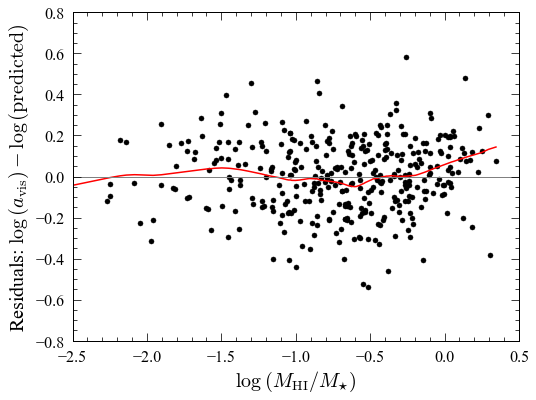

In [22]:
s4gxx_03, s4gyy_03 = GetSortedLoess1D(s4gdata.logfgas[ii_barred_D30_m9to11_Reh], resid_logbarsize_ReMstar, frac=0.3)

plot(s4gdata.logfgas[ii_barred_D30_m9to11_Reh], resid_logbarsize_ReMstar, 'ko', ms=5)
plot(s4gxx_03, s4gyy_03, 'r', lw=1.5)
axhline(0, color='0.5')
xlim(-2.5,0.5);ylim(-0.8,0.8)
xlabel(xtfgas);ylabel(ytresid)
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots:
    savefig(plotDir+"barsize-ReMstar-residuals_vs_logfgas.pdf")

### Plot: Right panel

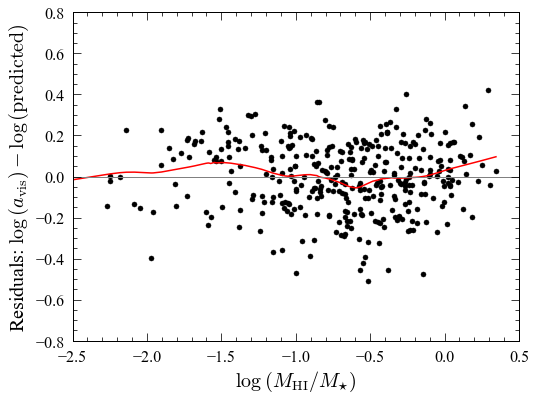

In [23]:
s4gxx_03, s4gyy_03 = GetSortedLoess1D(s4gdata.logfgas[ii_barred_D30_m9to11_Reh], resid_logbarsize_hMstar, frac=0.3)

plot(s4gdata.logfgas[ii_barred_D30_m9to11_Reh], resid_logbarsize_hMstar, 'ko', ms=5)
plot(s4gxx_03, s4gyy_03, 'r', lw=1.5)
axhline(0, color='0.5')
xlim(-2.5,0.5);ylim(-0.8,0.8)
xlabel(xtfgas);ylabel(ytresid)
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots:
    savefig(plotDir+"barsize-hMstar-residuals_vs_logfgas.pdf")

## Figure 6 -- Barsize vs Hubble type

plots/barsize-vs-T.pdf

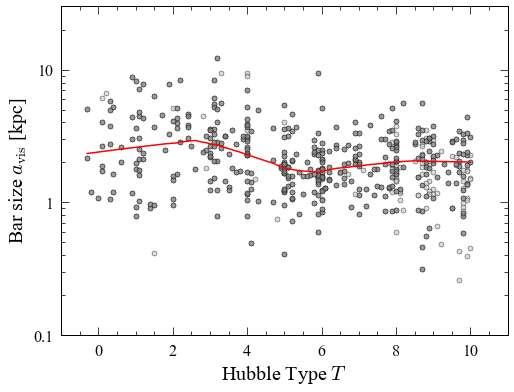

In [46]:
s4gxx, s4gyy = GetSortedLoess1D(s4gdata.t_leda[ii_barred_D30_m9to11], np.log10(s4gdata.sma_dp_kpc2[ii_barred_D30_m9to11]), frac=0.3)
s4gyy = 10**s4gyy

semilogy(s4gdata.t_leda[ii_barred_limited2], s4gdata.sma_dp_kpc2[ii_barred_limited2], 'ko', mfc='0.8', ms=5, alpha=0.7)
semilogy(s4gdata.t_leda[ii_barred_D30_m9to11], s4gdata.sma_dp_kpc2[ii_barred_D30_m9to11], 'ko', mfc='0.5', ms=5, alpha=0.7)
semilogy(s4gxx,s4gyy, 'r', lw=1.5)
xlim(-1,11);ylim(0.1,30)
xlabel(r'Hubble Type $T$')
ylabel(ytbarsize_kpc)
pu.MakeNiceLogAxes(whichAxis="y")
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots:
    savefig(plotDir+"barsize-vs-T.pdf")

## Figure 7 -- Residuals of barsize vs Hubble type (2-panel)

plots/barsize-residuals-vs-T_2panel -- **assembled in Adobe Illustrator**:
   1. barsize-ReMstar-residuals_vs_T.pdf
   2. barsize-hMstar-residuals_vs_T.pdf

Note that we can re-use the residuals to the barsize-vs-logMstar+Re/h fits from Section 5 above.

### Left panel

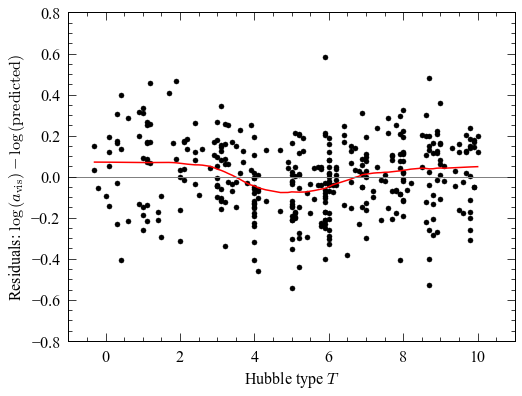

In [25]:
htype_Reh = s4gdata.t_leda[ii_barred_D30_m9to11_Reh]

s4gxx, s4gyy = GetSortedLoess1D(htype_Reh, resid_logbarsize_ReMstar, frac=0.3)

plot(htype_Reh, resid_logbarsize_ReMstar, 'ko', ms=5)
plot(s4gxx, s4gyy, 'r-', lw=1.5)
axhline(0,color='0.5')
xlim(-1,11);ylim(-0.8,0.8)
xlabel(r"Hubble type $T$", fontsize=16);ylabel(ytresid, fontsize=16)
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots:
    savefig(plotDir+"barsize-ReMstar-residuals_vs_T.pdf")

### Right panel

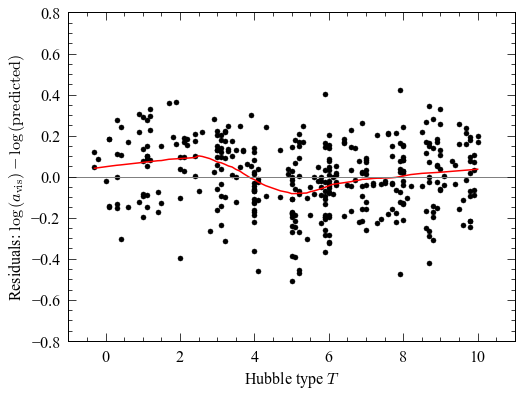

In [26]:
htype_Reh = s4gdata.t_leda[ii_barred_D30_m9to11_Reh]

s4gxx, s4gyy = GetSortedLoess1D(htype_Reh, resid_logbarsize_hMstar, frac=0.3)

plot(htype_Reh, resid_logbarsize_hMstar, 'ko', ms=5)
plot(s4gxx, s4gyy, 'r-', lw=1.5)
axhline(0,color='0.5')
xlim(-1,11);ylim(-0.8,0.8)
xlabel(r"Hubble type $T$", fontsize=16);ylabel(ytresid, fontsize=16)
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots:
    savefig(plotDir+"barsize-hMstar-residuals_vs_T.pdf")

## Figure 8 -- Residuals of Re-Mstar or h-Mstar vs bar sizes

[~/Documents/Working/Projects/Project_BarSizes/notebooks/barsizes_galaxy_scaling_relations.ipynb]

plots/size-vs-mstar_residuals-vs-barsize.pdf


### Compute residuals of fits to log(Mstar) vs R_e or vs h

In [27]:
# broken-linear fit to Main Spiral Sample: log R_e vs logMstar
predRe = simplefunc_brokenlinear(fitDict['Re-vs-Mstar_Reh'], s4gdata.logmstar)
residRe = logRe_all - predRe

# broken-linear fit to Main Spiral Sample: log h vs logMstar
predh = simplefunc_brokenlinear(fitDict['h-vs-Mstar_Reh'], s4gdata.logmstar)
residh = logh_all - predh


# compute simple linear fits to residuals as a function of barsize
def flin( x, a, b ):
	return a + b*x

p0_lin = [-2, 0.3]
pp_lin_reresid, pcov = scipy.optimize.curve_fit(flin, logbarsize_all[ii_barred_D30_m9to11_Reh], residRe[ii_barred_D30_m9to11_Reh], p0=p0_lin)
pp_lin_hresid, pcov = scipy.optimize.curve_fit(flin, logbarsize_all[ii_barred_D30_m9to11_Reh], residh[ii_barred_D30_m9to11_Reh], p0=p0_lin)

### Make 2-panel plot

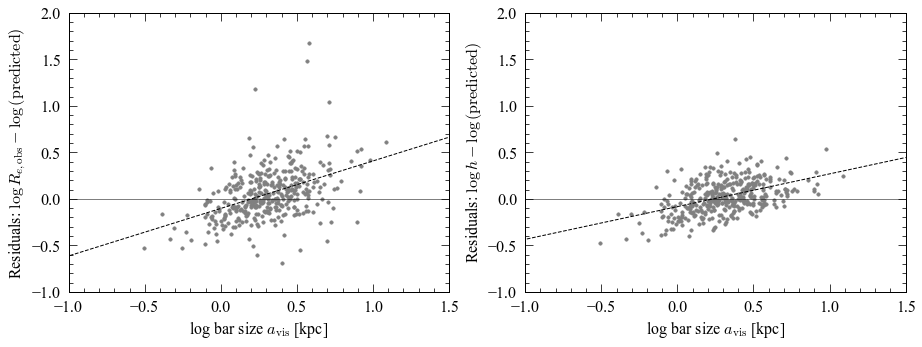

In [30]:
xx = np.arange(-1.5,1.6,0.1)

f,(ax1,ax2) = subplots(1,2, figsize=(15,5))

ax1.plot(logbarsize_all[ii_barred_D30_m9to11_Reh], residRe[ii_barred_D30_m9to11_Reh], 'o', color='0.5', ms=3.5)
ax1.plot(xx, pp_lin_reresid[0] + pp_lin_reresid[1]*xx, 'k--')
ax1.axhline(0, lw=0.5)
ax1.set_ylim(-1,2.0)
ax1.set_xlim(-1.0,1.5)
ax1.set_xlabel(r"log bar size $a_{\rm vis}$ [kpc]", fontsize=16)
ax1.set_ylabel(ytresid_Re, fontsize=16)

ax2.plot(logbarsize_all[ii_barred_D30_m9to11_Reh], residh[ii_barred_D30_m9to11_Reh], 'o', color='0.5', ms=3.5)
ax2.plot(xx, pp_lin_hresid[0] + pp_lin_hresid[1]*xx, 'k--')
ax2.axhline(0, lw=0.5)
ax2.set_ylim(-1,2.0)
ax2.set_xlim(-1.0,1.5)
ax2.set_xlabel(r"log bar size $a_{\rm vis}$ [kpc]", fontsize=16)
ax2.set_ylabel(ytresid_h, fontsize=16)

if savePlots:
    plt.savefig(plotDir+"size-vs-mstar_residuals-vs-barsize.pdf")

## Figure 9 -- Scaling relations: R_e or h vs logMstar: barred, unbarred, all (2-panel)

plots/size-vs-mstar_barred-v-unbarred-loess_2panel.pdf --> size-vs-mstar_barred-v-unbarred-loess_2panel_tweaked.pdf

This is generated in this notebook as a 2-panel figure; the bounding-box/canvas is then
tweaked in Adobe Illustrator.

In [25]:
s4gxx, loessFit_Re = GetSortedLoess1D(s4gdata.logmstar[ii_all_Reh], np.log10(s4gdata.Re_kpc[ii_all_Reh]), frac=0.3)
s4gxx_barred, loessFit_Re_barred = GetSortedLoess1D(s4gdata.logmstar[ii_barred_Reh], np.log10(s4gdata.Re_kpc[ii_barred_Reh]), frac=0.3)
s4gxx_unbarred, loessFit_Re_unbarred = GetSortedLoess1D(s4gdata.logmstar[ii_unbarred_Reh], np.log10(s4gdata.Re_kpc[ii_unbarred_Reh]), frac=0.3)
loessFit_Re = 10**loessFit_Re
loessFit_Re_barred = 10**loessFit_Re_barred
loessFit_Re_unbarred = 10**loessFit_Re_unbarred

s4gxx, s4gyy = GetSortedLoess1D(s4gdata.logmstar[ii_all_Reh], logh_all[ii_all_Reh], frac=0.3)
loessFit_h = s4gyy
s4gxx_barred, s4gyy_barred = GetSortedLoess1D(s4gdata.logmstar[ii_barred_Reh], logh_all[ii_barred_Reh], frac=0.3)
loessFit_h_barred = s4gyy_barred
s4gxx_unbarred, s4gyy_unbarred = GetSortedLoess1D(s4gdata.logmstar[ii_unbarred_Reh], logh_all[ii_unbarred_Reh], frac=0.3)
loessFit_h_unbarred = s4gyy_unbarred
loessFit_h = 10**loessFit_h
loessFit_h_barred = 10**loessFit_h_barred
loessFit_h_unbarred = 10**loessFit_h_unbarred

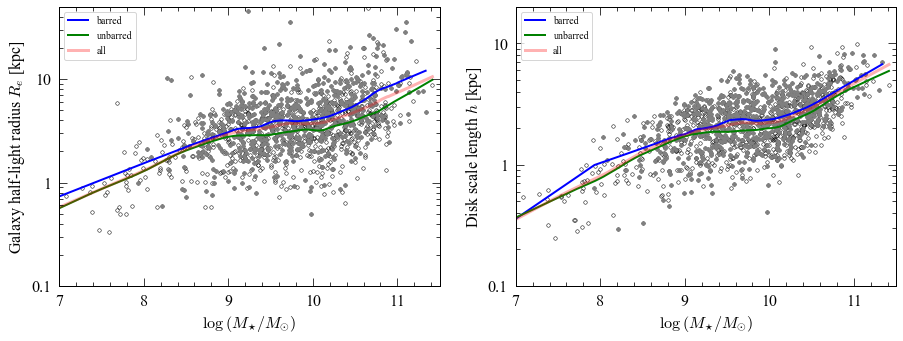

In [26]:
f,(ax1,ax2) = subplots(1,2, figsize=(15,5))

ax1.semilogy(s4gdata.logmstar, s4gdata.Re_kpc, 'o', mec='k', mfc="None", ms=3.5)
ax1.semilogy(s4gdata.logmstar[ii_barred], s4gdata.Re_kpc[ii_barred], 'o', color="0.5", ms=3.5)
ax1.plot(s4gxx_barred, loessFit_Re_barred, 'b', lw=2, label='barred')
ax1.plot(s4gxx_unbarred, loessFit_Re_unbarred, 'g', lw=2, label='unbarred')
ax1.plot(s4gxx, loessFit_Re, 'r-', lw=3, label='all', alpha=0.3)

ax1.set_xlim(7,11.5);ax1.set_ylim(0.1,50)
ax1.legend()
pu.MakeNiceLogAxes('y', axisObj=ax1)
ax1.set_xlabel(xtmstar, fontsize=16); ax1.set_ylabel(xtRe_kpc, fontsize=16)

ax2.semilogy(s4gdata.logmstar, s4gdata.h_kpc, 'o', mfc="None", mec="k", ms=3.5)
ax2.semilogy(s4gdata.logmstar[ii_barred], s4gdata.h_kpc[ii_barred], 'o', color="0.5", ms=3.5)
ax2.plot(s4gxx_barred, loessFit_h_barred, 'b', lw=2, label='barred')
ax2.plot(s4gxx_unbarred, loessFit_h_unbarred, 'g', lw=2, label='unbarred')
ax2.plot(s4gxx, loessFit_h, 'r-', lw=3, label='all', alpha=0.3)
ax2.set_xlim(7,11.5);ax2.set_ylim(0.1,20)
ax2.legend()
pu.MakeNiceLogAxes(whichAxis="y", axisObj=ax2)
ax2.set_xlabel(xtmstar, fontsize=16); ax2.set_ylabel(xth_kpc, fontsize=16)

if savePlots:
    savefig(plotDir+"size-vs-mstar_barred-v-unbarred-loess_2panel.pdf")


## Figure A1 -- Scaling relations: R_e or h vs logMstar: all (2-panel) [Appendix]

plots/size-vs-mstar-with-fits_2panel.pdf

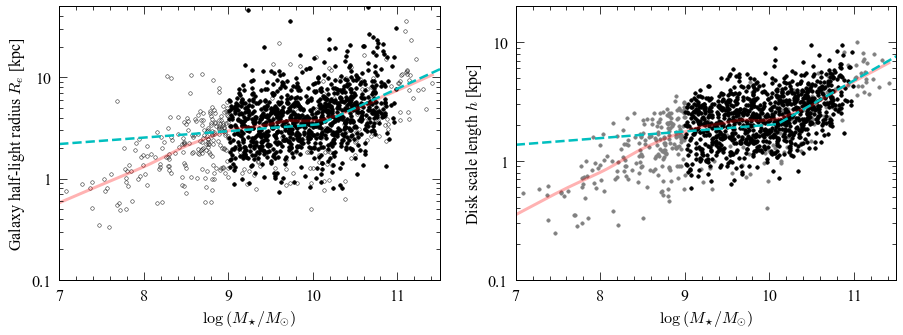

In [27]:
# broken-linear fit to Main Spiral Sample: log R_e vs logMstar
#a1, b1, x_brk, b2 = pp_brokenlin_revsmstar
xx = np.arange(7,12,0.05)
predRe = 10**simplefunc_brokenlinear(fitDict['Re-vs-Mstar_Reh'], xx)

# broken-linear fit to Main Spiral Sample: log h vs logMstar
#a1, b1, x_brk, b2 = pp_brokenlin_hvsmstar
xx = np.arange(7,12,0.05)
predh = 10**simplefunc_brokenlinear(fitDict['h-vs-Mstar_Reh'], xx)


# make the plots
f,(ax1,ax2) = subplots(1,2, figsize=(15,5))

ax1.semilogy(s4gdata.logmstar, s4gdata.Re_kpc, 'o', mfc='None', mec='0.1', ms=3.5)
ax1.semilogy(s4gdata.logmstar[ii_all_Reh_m9to11], s4gdata.Re_kpc[ii_all_Reh_m9to11], 'o', color="k", ms=3.5)
ax1.plot(s4gxx, loessFit_Re, 'r-', lw=3, label='all', alpha=0.3)
ax1.semilogy(xx, predRe, 'c--', lw=2.5)

ax1.set_xlim(7,11.5);ax1.set_ylim(0.1,50)
pu.MakeNiceLogAxes('y', axisObj=ax1)
ax1.set_xlabel(xtmstar, fontsize=16); ax1.set_ylabel(xtRe_kpc, fontsize=16)

ax2.semilogy(s4gdata.logmstar, s4gdata.h_kpc, 'o', color='0.5', ms=3.5)
ax2.semilogy(s4gdata.logmstar[ii_all_Reh_m9to11], s4gdata.h_kpc[ii_all_Reh_m9to11], 'o', color="k", ms=3.5)
ax2.plot(s4gxx, loessFit_h, 'r-', lw=3, label='all', alpha=0.3)
ax2.semilogy(xx, predh, 'c--', lw=2.5)

ax2.set_xlim(7,11.5);ax2.set_ylim(0.1,20)
pu.MakeNiceLogAxes(whichAxis="y", axisObj=ax2)
ax2.set_xlabel(xtmstar, fontsize=16); ax2.set_ylabel(xth_kpc, fontsize=16)

# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)

savefig(plotDir+"size-vs-mstar-with-fits_2panel.pdf")

## Figure A2 -- Gas mass ratio vs logMstar

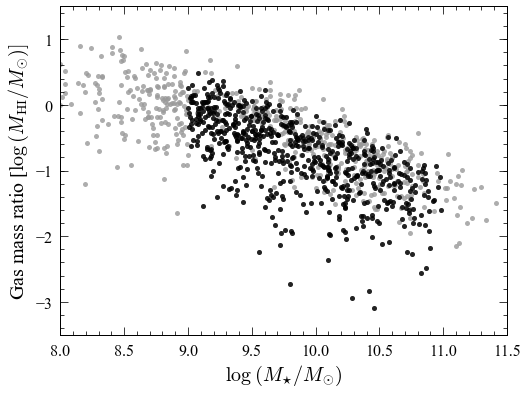

In [28]:
plot(s4gdata.logmstar[ii_spirals], s4gdata.logfgas[ii_spirals], 'o', mfc='0.6', mec='None',ms=5, alpha=0.8, zorder=-1)
plot(s4gdata.logmstar[ii_all_D30_m9to11], s4gdata.logfgas[ii_all_D30_m9to11], 'ko', mec='None',ms=5, alpha=0.8, zorder=-1)
xlim(8,11.5);ylim(-3.5,1.5)
xlabel(xtmstar)
ylabel(r'Gas mass ratio [$\log \, (M_{\rm HI} / M_{\odot})]$')

# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)

if savePlots:
    savefig(plotDir+"logfgas-vs-mstar.pdf")